In [1]:
from PIL import Image
import torchvision.transforms.v2 as T
import matplotlib.pyplot as plt
from matplotlib.axes._axes import Axes
import copy
import torch
import torch.fft as tfft
import torch.nn.functional as F
from skimage import filters
from scipy import io
from IPython.display import Audio
import numpy as np

orig_imshow = Axes.imshow

def torchshow(self, img, *args, **kwargs):
    return orig_imshow(self, img.permute(1, 2, 0), cmap="gray", *args, **kwargs)

Axes.imshow = torchshow

## TOC
1. Demonstrate Aliasing
    1. Audio
    2. Images
2. Sampling a 1D Signal
    1. Sampling in Time Domain
    2. Fourier Transform + Sampling in Frequency Domain
3. Nyquist-Shannon Sampling Theorem
4. Sampling a 2D Signal
    1. Sampling in Spatial Domain
    2. 2D Fourier Transform + Sampling in *k*-space
5. Avoiding Aliasing with Linear Filters
    1. What is a Linear Filter?
    2. Applying Linear Filters in Spatial Domain
    3. Applying Linear Filters in *k*-space
    4. Ringing Artifacts from Naive Filtering

## What is Aliasing?
### Aliasing on Images
Images as well as audio are signals, in 2D and 1D respectively. Anyone who's ever worked with digital images knows that high resolution images do not only require a lot of storage, but also a lot of computational power to process. Therefore, we're often interested in reducing an image's resolution before applying an operation on it, such as passing it through a neural network or running an image processing algorithm on it. The simplest way of reducing an image's resolution by a factor $i^2$ is to simply ignore all pixels except every $i$-th in both directions.

This is exactly what's implemented and shown below for $i=3$, and as you can see all images show artifacts in the form of [Moiré patterns](https://en.wikipedia.org/wiki/Moir%C3%A9_pattern). In the first two images they are particularly well visible, but you can also see them really prominently on the rear window of the bus in the last image. 

This pattern is exactly how *Aliasing* manifests itself in many cases!

[torch.Size([1, 512, 512]), torch.Size([3, 756, 622]), torch.Size([3, 505, 900])]


/Users/lionelpeer/micromamba/envs/imgproc/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Text(0.5, 1.0, 'Naive Downsampling by Factor 3')

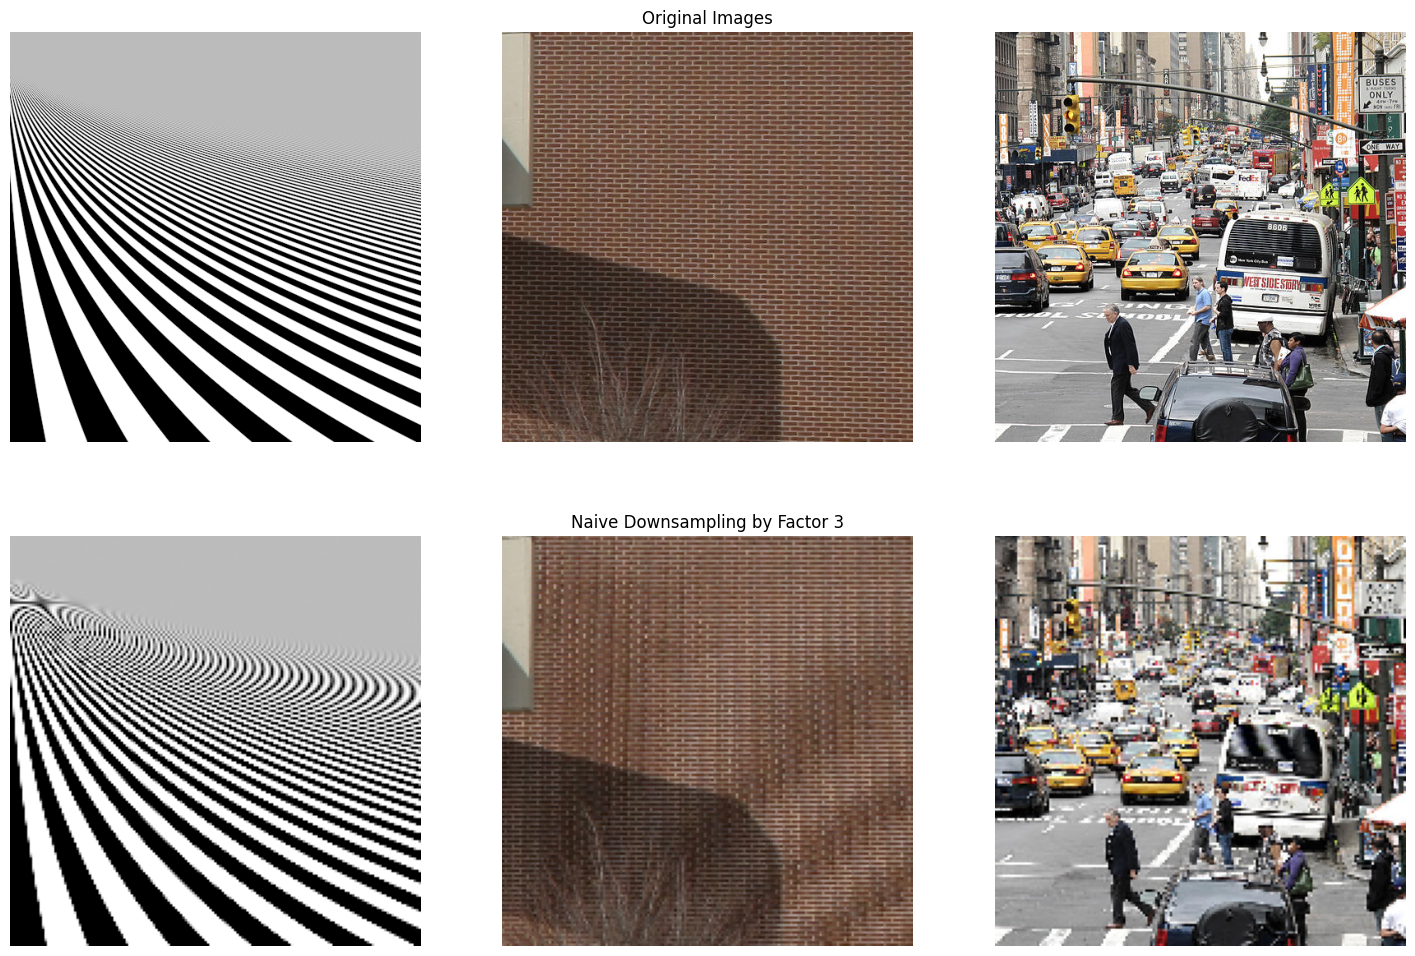

In [2]:
imgs = ["antialias_img.png", "brick_wall.jpg", "city_scene.jpg"]
imgs = [Image.open(img) for img in imgs]
imgs = [T.ToTensor()(img) for img in imgs]
print([img.shape for img in imgs])
imgs = [T.CenterCrop(500)(img) for img in imgs]
#imgs = [img.mean(0, keepdim=True) for img in imgs]

fig, ax = plt.subplots(2, 3, figsize=(18, 12))
for i, img in enumerate(imgs):
    ax[0,i].imshow(img)
    ax[0,i].axis("off")
ax[0,1].set_title("Original Images")

down_factor = 3
for i, img in enumerate(imgs):
    ax[1,i].imshow(img[:, ::down_factor, ::down_factor])
    ax[1,i].axis("off")
ax[1,1].set_title(f"Naive Downsampling by Factor {down_factor}")

### Aliasing on Audio

In [3]:
freq, data = io.wavfile.read("song.wav")
data = data[:freq*20, 0] # 20 seconds, only one channel

down_factor = 10
data_subsampled = data[::down_factor]
freq_downsampled = freq / down_factor

In [27]:
Audio(data, rate=freq)

In [28]:
Audio(data_subsampled, rate=freq_downsampled)

In [ ]:
x = torch.arange(-1, 1, 2 / 1000)
f = lambda n: 1 / (2*n+1) * torch.sin(2 * torch.pi * (2*n+1) * x)
y = torch.stack([f(n) for n in range(0, 1000)])
y = 4 / torch.pi * y.sum(0)

## Fundamentals – Aliasing and the Nyquist-Shannon Sampling Theorem

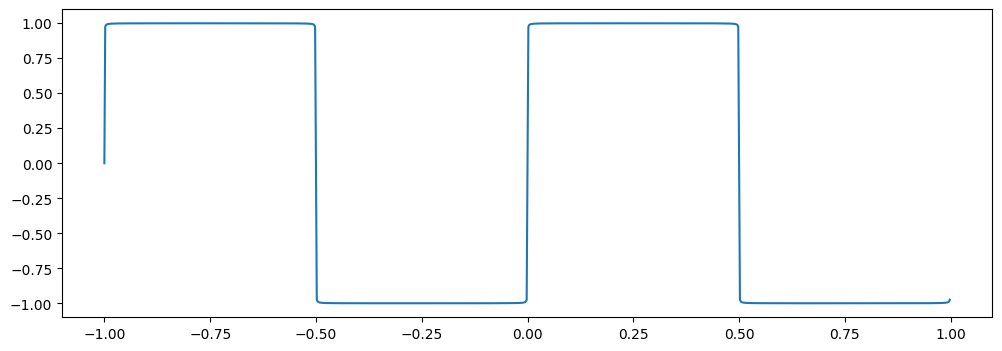

In [32]:
x = torch.arange(-1, 1, 2 / 1000)
f = lambda n: 1 / (2*n+1) * torch.sin(2 * torch.pi * (2*n+1) * x)
y = torch.stack([f(n) for n in range(0, 1000)])
y = 4 / torch.pi * y.sum(0)

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(x, y)

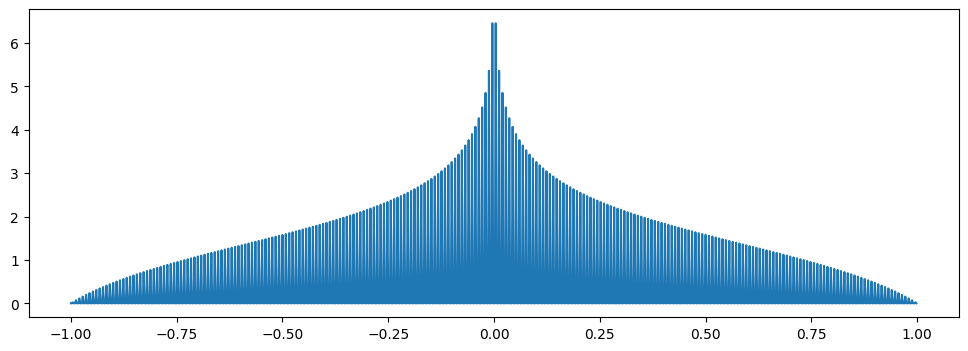

In [33]:
y_hat = tfft.fftshift(tfft.fft(y))
y_hat = y_hat.abs().log1p()

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(x, y_hat)

$$
f(t) = \frac{4}{\pi} \sum_{n=0}^{\infty} \frac{1}{2n+1} \sin \left(2\pi (2n+1) f_0 t\right)
$$

## Fundamentals – Filters and Fourier

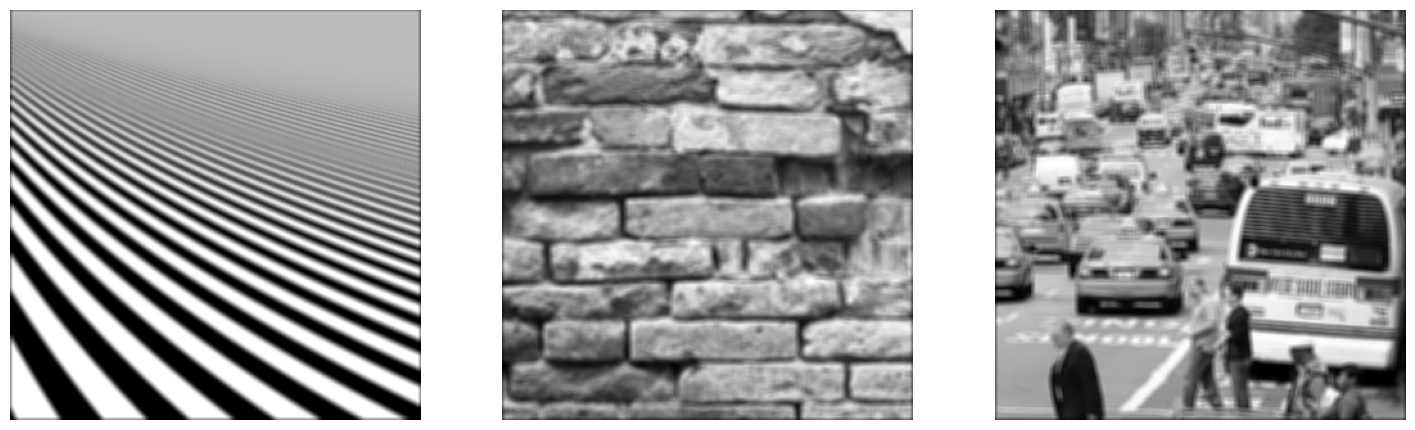

In [11]:
box_filter = torch.ones((1, 5, 5))
box_filter /= box_filter.sum()
imgs_box_filtered = [F.conv2d(img.unsqueeze(0), box_filter.unsqueeze(0), padding="same").squeeze(0) for img in imgs]

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
for i, img in enumerate(imgs_box_filtered):
    ax[i].imshow(img)
    ax[i].axis("off")

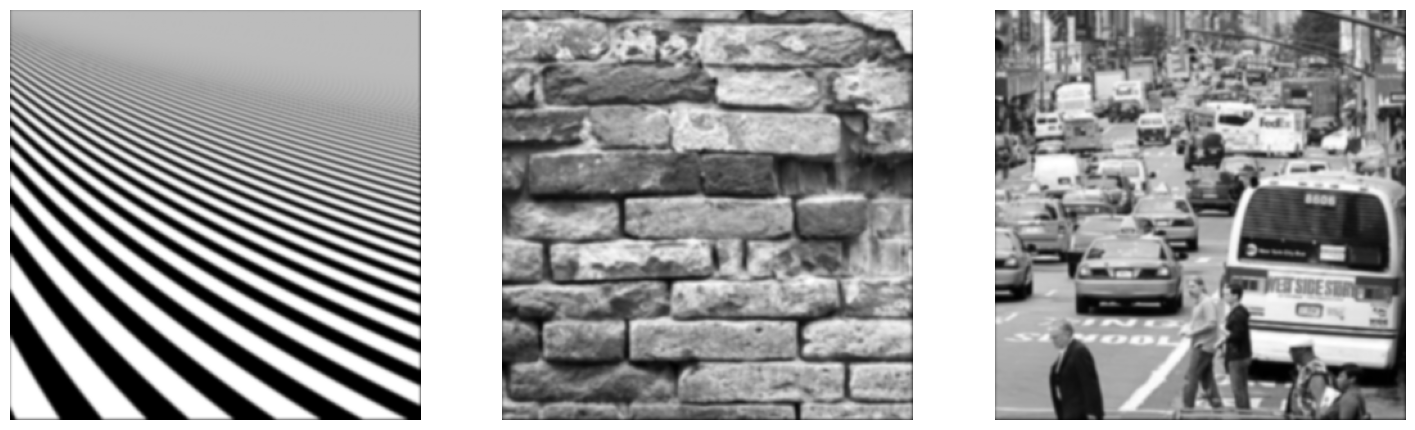

In [15]:
std = 2.0

x = torch.arange(-4, 4, 6 / 5)
gaussian_filter_1d = torch.exp(-x**2 / (std**2))
gaussian_filter_2d = torch.matmul(gaussian_filter_1d[:, None], gaussian_filter_1d[None, :])
gaussian_filter_2d /= gaussian_filter_2d.sum()
imgs_gaussian_filtered = [F.conv2d(img.unsqueeze(0), gaussian_filter_2d[None, None, : , :], padding="same").squeeze(0) for img in imgs]

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
for i, img in enumerate(imgs_gaussian_filtered):
    ax[i].imshow(img)
    ax[i].axis("off")